# Схема переменных направлений

In [520]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Область  определения:

In [519]:
lim = {}
lim['x'] = (0, 1)
lim['y'] = (0, 2)
lim['t'] = (0, 1)

### Число узлов сетки

In [220]:
N = {}
N['x'] = 30
N['y'] = 60
N['t'] = 100

In [ ]:
h['x'] = (lim['x'][1] - lim['x'][0]) / (N['x'] + 1)
h['y'] = (lim['y'][1] - lim['y'][0]) / (N['y']) # граничные условтя второго рода
h['t'] = (lim['x'][1] - lim['x'][0]) / (N['x'] + 1)

In [503]:
def x(n):
    return lim['x'][0] + h['x']*n

def y(n):
    return lim['y'][0] + h['y']*n - h['y'] / 2

def t(n):
    return lim['t'][0] + h['t']*n

In [539]:
def f(i, j, k):
    return (1 / (2 - x(i))) * \
    (1 - x(i) + 2*t(k)*np.sin(np.pi*x(i) * np.cosh(np.pi*y(j))) / \
     np.pi*np.sinh(2*np.pi) ) 
    
def L2(u, i, j):
    return (u[i,j+1] - 2*u[i][j] + u[i][j-1]) / h['y']**2

def L1(u, i, j):
    return (u[i-1,j] - 2*u[i,j] + u[i+1,j]) / h['x']**2  + (2*x(i) - 4) / (2 - x(i))**2 * (u[i+1,j] - u[i-1,j])/ h['x']

def u0(i, j):
    return np.sin(2*np.pi*x(i)) / (2 - x(i))

In [540]:
# x - i
# y - j
# t - k

In [541]:
w = np.zeros((N['x']+1, N['y']+1))
u = np.zeros((N['t']+1, N['x']+1, N['y']+1))

In [542]:
## Начальные условия
for i in range(N['x']+1):
    for j in range(N['y']+1):
        u[0,i,j] = u0(i,j)
        
## Граничные условия по x
for k in range(N['t']+1):
    for j in range(N['y']+1):
        u[k,0,j] = t(k)
        u[k,N['x'],j] = 0
        

In [543]:
A_y = np.zeros(N['y'])
B_y = np.zeros(N['y'])
C_y = np.zeros(N['y'])
F_y = np.zeros(N['y'])


A_x = np.zeros(N['x'])
B_x = np.zeros(N['x'])
C_x = np.zeros(N['x'])
F_x = np.zeros(N['x'])

for k in range(1, N['t']):
    # переход на слой k+1

    for j in range(0, N['y'] +1):
        w[0,j] = t(k+0.5)
        w[1,j] = 0

    # переход на квазислой
    
    for i in range(1, N['x']):
        # готовим прогоночные коэффициенты
        for j in range(1,N['y']):
            
            A_y[j] = 1 / h['y']**2
            C_y[j] = 2 / h['y']**2 + 2 / h['t']
            B_y[j] = 1 / h['y']**2

            F_y[j] = L1(u[k], i, j) + f(i, j, k+0.5) + 2*u[k, i, j] / h['t']

        # прогонка
        # граничные условия по y
        k1 = 1
        k2 = 1
        m2 = t(k)**2 * np.sin(np.pi * x(i)) / (2 - x(i))

        w[i] = TMA(A_y, B_y, C_y, F_y, k2=k2, m2=m2)    

    # переход на новый слой

    for j in range(1,N['y']):
    
        # готовим прогоночные коэффициенты
        for i in range(1, N['x']):

            A_x[i] = 1 / h['x']**2 - (x(i) - 2) / (2 - x(i))**2 / h['x']
            C_x[i] = 2 / h['x']**2 + 2 / h['t']
            B_x[i] = 1 / h['x']**2 + (x(i) - 2) / (2 - x(i))**2 / h['x']

            F_x[i] = L2(w, i, j) + 2*w[i,j] / h['t'] + f(i, j, k+0.5)
        
        #метод прогонки
        
        m1 = t(k+1)
        u[k+1, :, j] = TMA(A_x, B_x, C_x, F_x, m1=m1)

        # граничные условия
        u[k+1,:,0] = u[k+1,:,0]
        for i in range(1,N['x']):
            u[k+1,i,N['y']] = u[k+1,i,N['y']-1] + h['y']*h['y']*t(k+1)**2*np.sin(np.pi * x(i)) / (2 - x(i))

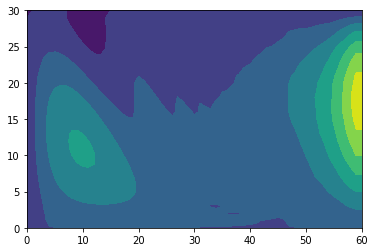

In [548]:
plt.contourf(u[-1])
plt.show()

In [545]:
# y0 = k1*y1 + m1
# yN = k2*yN-1 + m2

# A * x_n-1 - C_n * x_n + B * x_n+1 = -F_n

def TMA(A, B, C, F, k1=0, k2=0, m1=0, m2=0):
    
    N = C.shape[0]
    
    x = np.zeros(N+1)
    
    alpha = np.zeros(N+1)
    beta = np.zeros(N+1)
    
    alpha[0] = k1
    beta[0] = m1

    for n in range(1,N):
        alpha[n] = B[n] / (C[n] - A[n]*alpha[n-1])
        beta[n] = (F[n] + A[n]*beta[n-1]) / (C[n] - A[n]*alpha[n-1])
            
    x[N] = (m2 + k2*beta[N-1]) / (1 - k2*alpha[N-1])
    
    for n in range(N-1, -1, -1):
        x[n] = alpha[n]*x[n+1] + beta[n]
        
    return x

In [546]:
A = np.zeros(M.shape[0])
B = np.zeros(M.shape[0])
C = np.zeros(M.shape[0])

for i in range(M.shape[0]):
    C[i] = M[i,i]
    
for i in range(1, M.shape[0]):
    A[i] = M[i,i-1]

for i in range(M.shape[0]-1):
    B[i] = M[i,i+1]

In [446]:
def f(x):
    return -x**2 + 6*x -7 + 3* np.sin(3*x)

In [488]:
Nx = 100
h_x = 7 / (Nx - 0.5)

x = np.linspace(0,7,Nx+1)
y = f(x)

A = np.zeros(Nx)
C = np.zeros(Nx)
B = np.zeros(Nx)
F = np.zeros(Nx)
for i in range(1,Nx):
    A[i] = 1/h_x**2
    C[i] = 2/h_x**2
    B[i] = 1/h_x**2
    F[i] = 2 + 27 * np.sin(3*h_x*i)
             
m1 = -7
k2 = 1
m2 = -12.93*h_x

Y = TMA(A,B,C,F, m1=m1, k2=k2, m2=m2)

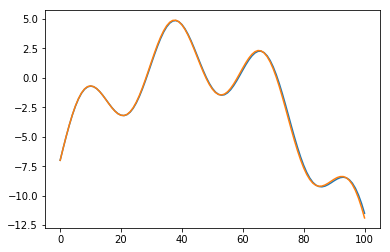

In [490]:
plt.plot(y)
plt.plot(Y)

In [501]:
Y[-1] - Y[-2]

-0.90964824120603005